# **Project Imports and Device Setup**

Below, we import all the necessary libraries and modules for data handling, visualization, metrics, 
and PyTorch functionalities. We then check whether a CUDA-capable GPU is available; if not, we fall back to the CPU.


In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    f1_score, recall_score, precision_score, 
    confusion_matrix, classification_report
)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, models, transforms

# Para métricas
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score

# Verificar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


# **Data Preparation and Loading**

In this section, we define the transformations for each dataset split (train, validation, test), 
convert images into tensors, and normalize them according to ImageNet statistics. We then create 
ImageFolder-based datasets and DataLoaders for efficient batch processing and shuffling, 
and finally gather information such as dataset sizes and class names.


In [2]:
import os
import torch
from torchvision import datasets, transforms

# Specify the path to your dataset directory
data_dir = '../data/'  # Adjust this path to match your dataset location

# Image size expected by the pre-trained model (e.g., ResNet50 typically uses 224x224)
input_size = 224

# Define transformations for the train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert single-channel images to 3 channels
        transforms.RandomResizedCrop(input_size),     # Randomly crop and resize to 224x224
        transforms.RandomHorizontalFlip(),            # Flip images horizontally with 50% probability
        transforms.ToTensor(),                        # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406],   # Mean of ImageNet dataset
                             [0.229, 0.224, 0.225])   # Std of ImageNet dataset
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(input_size),                # Resize the shorter edge to 224
        transforms.CenterCrop(input_size),            # Crop the center region of size 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets from their respective folders: train, val, test
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),    # e.g. '../data/train', '../data/val', '../data/test'
        data_transforms[x]
    )
    for x in ['train', 'val', 'test']
}

# Create DataLoaders for each dataset split
batch_size = 128
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=batch_size,
        shuffle=True if x == 'train' else False,  # Shuffle only the training set
        num_workers=2  # Adjust based on your system capabilities
    )
    for x in ['train', 'val', 'test']
}

# Retrieve the dataset sizes (number of images in train/val/test)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Retrieve class names from the training dataset
class_names = image_datasets['train'].classes
print("Classes found:", class_names)


Classes found: ['fractured', 'not fractured']


# **Check unbalanbced class**

In [3]:
from collections import Counter

for phase in ['train', 'val', 'test']:
    dataset = image_datasets[phase]
    class_labels = dataset.classes
    
    # Contar cuántas muestras hay de cada índice de clase
    counts = Counter(dataset.targets)

    print(f"\n=== Class distribution in {phase.upper()} ===")
    for class_idx, count in counts.items():
        print(f"Clase '{class_labels[class_idx]}': {count} imágenes")



=== Class distribution in TRAIN ===
Clase 'fractured': 4606 imágenes
Clase 'not fractured': 4634 imágenes

=== Class distribution in VAL ===
Clase 'fractured': 337 imágenes
Clase 'not fractured': 486 imágenes

=== Class distribution in TEST ===
Clase 'fractured': 238 imágenes
Clase 'not fractured': 262 imágenes


# **Training Function with Early Stopping**

This function trains the model while monitoring its validation accuracy. If the accuracy fails 
to improve beyond a specified threshold (`min_delta`) for a certain number of consecutive epochs 
(`patience`), training is stopped early. This helps to prevent overfitting and saves training time 
when no further improvement is observed.


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5, min_delta=0.0):
    """
    Train the model with Early Stopping based on 'val_acc'.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to be trained.
    criterion : torch.nn.Module
        The loss function (e.g., nn.CrossEntropyLoss).
    optimizer : torch.optim.Optimizer
        The optimizer (e.g., Adam, SGD, etc.).
    scheduler : torch.optim.lr_scheduler
        The learning rate scheduler (e.g., StepLR, ReduceLROnPlateau, etc.).
    num_epochs : int, optional
        Maximum number of epochs to train. Default is 10.
    patience : int, optional
        Number of consecutive epochs allowed without improvement in validation accuracy
        before stopping the training. Default is 5.
    min_delta : float, optional
        Minimum change in validation accuracy to be considered a significant improvement.
        Default is 0.0.
    """
    
    start_time = time.time()

    # Copy the initial model state so we can revert to it if needed
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # This dictionary will store the loss and accuracy curves over training
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Counter to keep track of how many epochs passed without any improvement
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training phase and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the data in the current phase
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in the training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Step the scheduler at the end of the training phase
                scheduler.step()

            # Compute epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Store in history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # If we're in the validation phase, check if there's an improvement
            if phase == 'val':
                if (epoch_acc - best_acc) > min_delta:
                    # Significant improvement detected
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    # No significant improvement
                    epochs_no_improve += 1

        print()

        # Early Stopping check
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered. No improvement in validation accuracy \
for {patience} consecutive epoch(s).")
            break

    # Training duration
    total_time = time.time() - start_time
    print(f'Training completed in {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# **Training History Visualization**

This function plots the training and validation accuracy and loss over all epochs. These visualizations 
help evaluate the model's performance, identify overfitting or underfitting, and assess whether the 
training process converged effectively.

In [5]:
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# **Model Initialization and Configuration**

Here, we load a pre-trained ResNet50 model on ImageNet, freeze its base layers so that only the 
final fully-connected layer is trainable, and update that layer to output two classes. 
We also define the loss function (CrossEntropyLoss), set up an Adam optimizer for the final layer, 
and initialize a learning rate scheduler to systematically reduce the learning rate every few epochs.


In [6]:
# === Model Definition and Setup ===
# Load a pre-trained ResNet50 model on ImageNet
model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

# Freeze parameters so we only train the final layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully-connected layer to output 2 classes instead of 1000
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU or CPU)
model = model.to(device)

# === Criterion and Optimizer ===
# Define the loss function
criterion = nn.CrossEntropyLoss()

# We only train the parameters of the new fully-connected layer
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# === Learning Rate Scheduler ===
# Decrease the LR every 7 epochs by multiplying it with gamma (0.1 in this case)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# **Model Training with Early Stopping**

Here, we train the model using the previously defined `train_model` function. The training process monitors 
validation accuracy and stops early if no significant improvement is observed for 5 consecutive epochs 
(`patience=5`). The learning rate is adjusted every few epochs using the specified scheduler.


Epoch 1/20
----------
train Loss: 0.5768 Acc: 0.7137
val Loss: 0.5239 Acc: 0.7278

Epoch 2/20
----------
train Loss: 0.4808 Acc: 0.7892
val Loss: 0.4635 Acc: 0.7910

Epoch 3/20
----------
train Loss: 0.4425 Acc: 0.8083
val Loss: 0.4605 Acc: 0.7764

Epoch 4/20
----------
train Loss: 0.4255 Acc: 0.8148
val Loss: 0.4460 Acc: 0.7849

Epoch 5/20
----------
train Loss: 0.4001 Acc: 0.8298
val Loss: 0.4411 Acc: 0.7886

Epoch 6/20
----------
train Loss: 0.3903 Acc: 0.8332
val Loss: 0.3870 Acc: 0.8469

Epoch 7/20
----------
train Loss: 0.3741 Acc: 0.8383
val Loss: 0.3985 Acc: 0.8335

Epoch 8/20
----------
train Loss: 0.3688 Acc: 0.8430
val Loss: 0.3922 Acc: 0.8323

Epoch 9/20
----------
train Loss: 0.3779 Acc: 0.8363
val Loss: 0.3872 Acc: 0.8457

Epoch 10/20
----------
train Loss: 0.3693 Acc: 0.8471
val Loss: 0.3911 Acc: 0.8323

Epoch 11/20
----------
train Loss: 0.3679 Acc: 0.8477
val Loss: 0.3893 Acc: 0.8420

Early stopping triggered. No improvement in validation accuracy for 5 consecutive epo

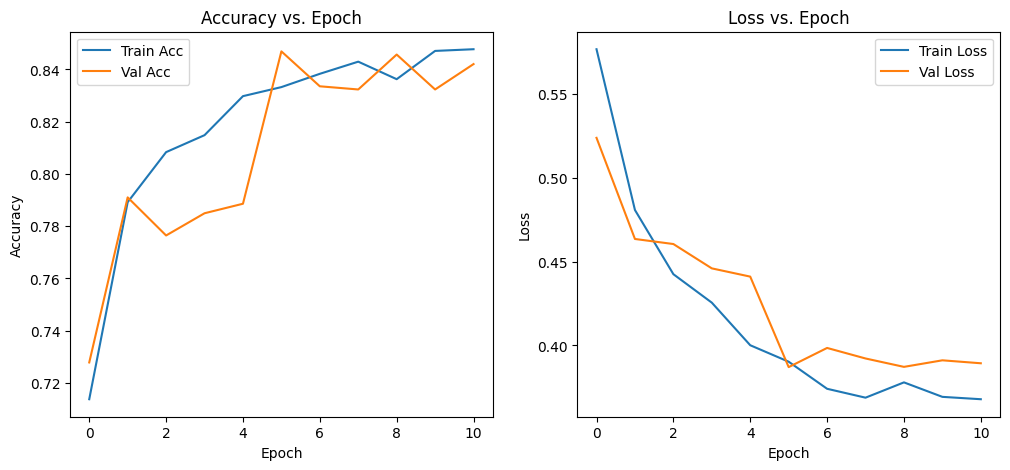

In [7]:
model, history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20,    # Potentially a larger number
    patience=5,       # Stop if 5 epochs in a row have no val_acc improvement
    min_delta=0.0     # Allow any improvement to be considered significant
)

plot_training_history(history)

# **Unfreeze more layers**

In [8]:
# 1. Load a fresh ResNet50
model_finetuned = models.resnet50(weights="ResNet50_Weights.DEFAULT")

# For ResNet50, layers are: layer1, layer2, layer3, layer4, then fc
# Example: unfreeze layer3, layer4, and fc
for name, param in model_finetuned.named_parameters():
    if 'layer3' in name or 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 3. Modify the final FC layer to match your number of classes
num_ftrs = model_finetuned.fc.in_features
model_finetuned.fc = nn.Linear(num_ftrs, 2)

# 4. Move the model to GPU/CPU
model_finetuned = model_finetuned.to(device)

# 5. Define a new criterion, optimizer, and scheduler
criterion_finetuned = nn.CrossEntropyLoss()

# For the optimizer, now you are training *all* layers, not just the FC
optimizer_finetuned = optim.Adam(model_finetuned.parameters(), lr=1e-4)

scheduler_finetuned = lr_scheduler.StepLR(optimizer_finetuned, step_size=7, gamma=0.1)


Epoch 1/20
----------
train Loss: 0.3773 Acc: 0.8264
val Loss: 0.1473 Acc: 0.9405

Epoch 2/20
----------
train Loss: 0.1186 Acc: 0.9513
val Loss: 0.0731 Acc: 0.9745

Epoch 3/20
----------
train Loss: 0.0879 Acc: 0.9637
val Loss: 0.0758 Acc: 0.9721

Epoch 4/20
----------
train Loss: 0.0738 Acc: 0.9671
val Loss: 0.0630 Acc: 0.9818

Epoch 5/20
----------
train Loss: 0.0650 Acc: 0.9747
val Loss: 0.0381 Acc: 0.9878

Epoch 6/20
----------
train Loss: 0.0614 Acc: 0.9751
val Loss: 0.0381 Acc: 0.9878

Epoch 7/20
----------
train Loss: 0.0465 Acc: 0.9827
val Loss: 0.0851 Acc: 0.9623

Epoch 8/20
----------
train Loss: 0.0430 Acc: 0.9823
val Loss: 0.0346 Acc: 0.9878

Epoch 9/20
----------
train Loss: 0.0383 Acc: 0.9851
val Loss: 0.0302 Acc: 0.9903

Epoch 10/20
----------
train Loss: 0.0392 Acc: 0.9855
val Loss: 0.0271 Acc: 0.9903

Epoch 11/20
----------
train Loss: 0.0368 Acc: 0.9847
val Loss: 0.0297 Acc: 0.9903

Epoch 12/20
----------
train Loss: 0.0297 Acc: 0.9874
val Loss: 0.0280 Acc: 0.9915

E

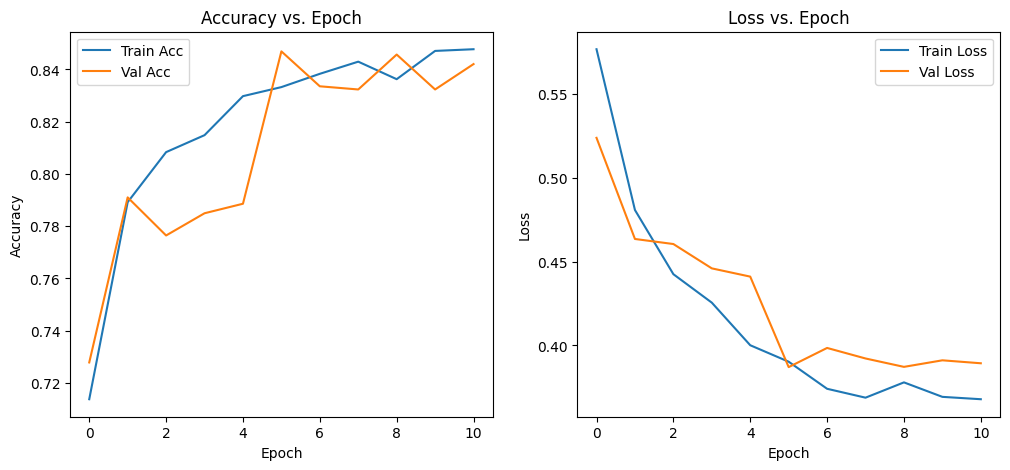

In [9]:
model_finetuned, history_finetuned = train_model(
    model=model_finetuned,
    criterion=criterion_finetuned,
    optimizer=optimizer_finetuned,
    scheduler=scheduler_finetuned,
    num_epochs=20,      # Or more, since fine-tuning can benefit from extra epochs
    patience=5,
    min_delta=0.0
)

plot_training_history(history)

# **Saving best model**

In [10]:
torch.save(model.state_dict(), "best_model.pth")
torch.save(model_finetuned.state_dict(), "best_model_finetuned.pth")

# **Model Evaluation and Metrics Visualization**

In this section, we evaluate the trained model on the test dataset. Predictions are compared to true labels to compute key metrics, including accuracy, F1-score, recall, and precision, which are displayed in a tabular format. Additionally, a classification report provides detailed metrics for each class. The confusion matrix is computed and visualized as both raw numbers and a heatmap to assess the model's performance across different classes.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report
)

def evaluate_model(model, dataloaders, device, class_names):
    """
    Evaluate the given model on the test set and display metrics.

    Parameters
    ----------
    model : torch.nn.Module
        The trained PyTorch model to evaluate.
    dataloaders : dict
        A dictionary of DataLoaders with keys like ['train', 'val', 'test'].
        We specifically use dataloaders['test'] here.
    device : torch.device
        The device (CPU or GPU) on which to run the evaluation.
    class_names : list
        A list of class names for display in the classification report
        and confusion matrix axis labels.

    Returns
    -------
    metrics_df : pd.DataFrame
        A DataFrame containing Accuracy, F1-score, Recall, and Precision.
    """
    # Set model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    acc = np.mean(all_preds == all_labels)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    prec = precision_score(all_labels, all_preds, average='weighted')

    # Create a DataFrame of metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'F1-score', 'Recall', 'Precision'],
        'Value': [acc, f1, rec, prec]
    })

    print("===== Test Set Metrics =====")
    display(metrics_df)

    # Classification report (per-class precision, recall, F1)
    print("\n===== Classification Report (per class) =====")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix (numeric)
    cm = confusion_matrix(all_labels, all_preds)
    print("===== Confusion Matrix (numeric) =====")
    print(cm)

    # Confusion matrix (heatmap)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return metrics_df

===== Test Set Metrics =====


,Metric,Value
0,Accuracy,0.798000
1,F1-score,0.797335
2,Recall,0.798000
3,Precision,0.799000



===== Classification Report (per class) =====
               precision    recall  f1-score   support

    fractured       0.81      0.75      0.78       238
not fractured       0.79      0.84      0.81       262

     accuracy                           0.80       500
    macro avg       0.80      0.80      0.80       500
 weighted avg       0.80      0.80      0.80       500

===== Confusion Matrix (numeric) =====
[[178  60]
 [ 41 221]]


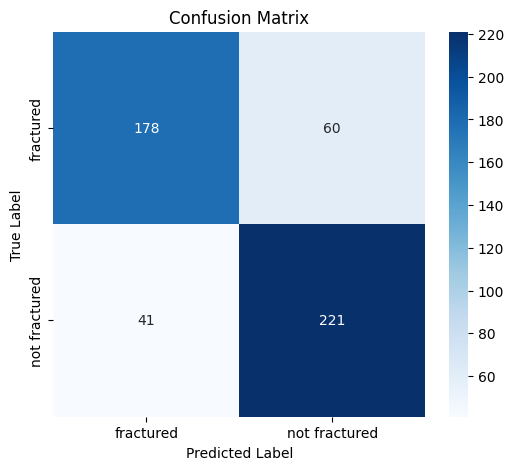

===== Test Set Metrics =====


,Metric,Value
0,Accuracy,0.988000
1,F1-score,0.987997
2,Recall,0.988000
3,Precision,0.988027



===== Classification Report (per class) =====
               precision    recall  f1-score   support

    fractured       0.99      0.98      0.99       238
not fractured       0.98      0.99      0.99       262

     accuracy                           0.99       500
    macro avg       0.99      0.99      0.99       500
 weighted avg       0.99      0.99      0.99       500

===== Confusion Matrix (numeric) =====
[[234   4]
 [  2 260]]


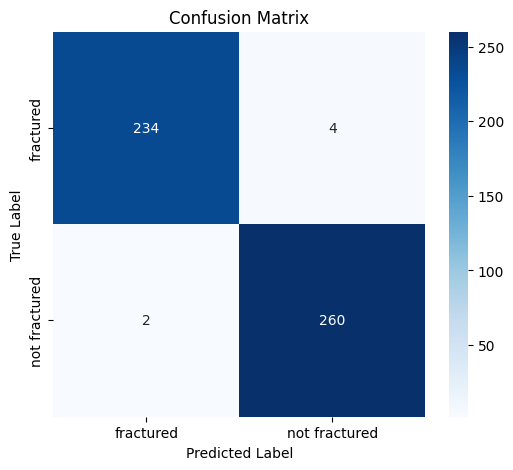

In [12]:
# Evaluate the original model
metrics_original = evaluate_model(model, dataloaders, device, class_names)

# Evaluate the fine-tuned model
metrics_finetuned = evaluate_model(model_finetuned, dataloaders, device, class_names)